Plan:
- Interpolate (1D) VLM
- Interpolate (2D) onto elevation map (cubic)
- Figure the colorbar problem out
- Write function for adjusted elevation
- Try the other library (ipyleaflet)

In [1]:
import pandas as pd
import geopandas as gpd
from osgeo import osr, gdal
import matplotlib.pyplot as plt
import numpy as np
import georasters as gr
import seaborn as sns
sns.set_theme(style="darkgrid")
from scipy.interpolate import griddata
import rasterio
import pyproj
from rasterio.plot import show

/Users/ngochoang/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
vlm_df = pd.read_excel('data.xls')
file = gr.from_file('Elevation.tif')
elevation_df = file.to_geopandas()

In [3]:
dataset = rasterio.open('Elevation.tif')
elevation = dataset.read(1)
print(dataset.profile)
print(dataset.crs)
print(dataset.count)
print(dataset.width, dataset.height)
print(dataset.bounds)

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': 32767.0, 'width': 2521, 'height': 1758, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00027777780000000054, 0.0, 53.99986135,
       0.0, -0.0002777777999999998, 24.700138706), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'interleave': 'band'}
EPSG:4326
1
2521 1758
BoundingBox(left=53.99986135, bottom=24.2118053336, right=54.700139183800005, top=24.700138706)


In [7]:
elevation_df.describe()

,row,col,value,x,y
count,1.789661e+06,1.789661e+06,1.789661e+06,1.789661e+06,1.789661e+06
mean,1.155950e+03,1.742289e+03,7.112559e+00,5.448383e+01,2.437904e+01
std,4.392793e+02,5.964249e+02,9.998245e+00,1.656736e-01,1.220221e-01
min,0.000000e+00,5.000000e+01,-8.900000e+01,5.401375e+01,2.421208e+01
25%,8.330000e+02,1.336000e+03,1.000000e+00,5.437097e+01,2.427236e+01
50%,1.233000e+03,1.878000e+03,3.000000e+00,5.452153e+01,2.435764e+01
75%,1.540000e+03,2.247000e+03,9.000000e+00,5.462403e+01,2.446875e+01
max,1.757000e+03,2.520000e+03,8.300000e+01,5.469986e+01,2.470014e+01


In [10]:
np.min(elevation[elevation != 32767])

-89

In [11]:
np.max(elevation[elevation != 32767])

83

In [4]:
vlm = vlm_df.drop(columns=['Station', 'VLM_std'])
vlm

,Longitude,Latitude,VLM
0,54.684594,24.796595,-0.207
1,54.115618,24.303783,1.413
2,53.848164,24.056855,-0.856
3,53.141386,24.147625,-0.724
4,52.587928,24.171598,1.812
5,52.763306,24.027073,-0.724
6,53.470797,23.925228,2.240
7,54.162907,24.134528,2.164
8,54.429235,24.539444,-0.683
9,54.319712,24.460688,-0.259


Question: How to space the grid? How many points?\
Idea: can create points that are 10m apart, calculate distances horizontally and vertically (is this possible) then divide by 10 to get the number of points

In [5]:
# Boundary points
# Top point: max latitude
top = vlm.iloc[vlm.idxmax().Latitude]
# Bottom point: min latitude
bottom = vlm.iloc[vlm.idxmin().Latitude]
# Left point: min longitude
left = vlm.iloc[vlm.idxmin().Longitude]
# Right point: max longitude
right = vlm.iloc[vlm.idxmax().Longitude]

In [6]:
# Artificial points for calculating distances
# point = (lon, lat)
# Top counter: lon = top, lat = bottom
top_counter = (top.Longitude, bottom.Latitude)
# Bottom counter: lon = bottom, lat = top
bottom_counter = (bottom.Longitude, top.Latitude)
# Left counter: lon = right, lat = left
left_counter = (right.Longitude, left.Latitude)
# Right counter: lon = left, lat = right
right_counter = (left.Longitude, right.Latitude)

In [7]:
# Arrays for plotting
top_pair = (np.array([top.Longitude, top_counter[0]]), np.array([top.Latitude, top_counter[1]]))
bottom_pair = (np.array([bottom.Longitude, bottom_counter[0]]), np.array([bottom.Latitude, bottom_counter[1]]))
left_pair = (np.array([left.Longitude, left_counter[0]]), np.array([left.Latitude, left_counter[1]]))
right_pair = (np.array([right.Longitude, right_counter[0]]), np.array([right.Latitude, right_counter[1]]))

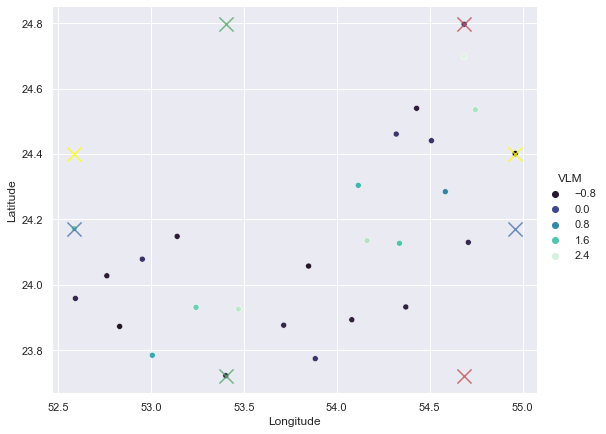

In [8]:
sns.relplot(x="Longitude", y="Latitude", hue="VLM", data=vlm, palette="mako", height=6, aspect=1.25)
plt.scatter(top_pair[0], top_pair[1], c='r', marker='x', s=200, alpha=0.8)
plt.scatter(bottom_pair[0], bottom_pair[1], c='g', marker='x', s=200, alpha=0.8)
plt.scatter(left_pair[0], left_pair[1], c='b', marker='x', s=200, alpha=0.8)
plt.scatter(right_pair[0], right_pair[1], c='yellow', marker='x', s=200, alpha=0.8)

In [9]:
# https://www.geeksforgeeks.org/program-distance-two-points-earth/
from math import radians, cos, sin, asin, sqrt
def distance(lon1, lat1, lon2, lat2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in meters. Use 3956 for miles
    r = 6371*1000
      
    # calculate the result
    return(c * r)

In [10]:
# Distances of vertical pairs (top & bottom)
ver_top = distance(top.Longitude, top.Latitude, top_counter[0], top_counter[1])
ver_bottom = distance(bottom.Longitude, bottom.Latitude, bottom_counter[0], bottom_counter[1])
# Distances of horizontal pairs (left & right)
hor_left = distance(left.Longitude, left.Latitude, left_counter[0], left_counter[1])
hor_right = distance(right.Longitude, right.Latitude, right_counter[0], right_counter[1])

In [11]:
ver_top, ver_bottom, hor_left, hor_right

(119547.22236453801,
 119547.22236453801,
 240586.98780873933,
 240152.87703462725)

In [12]:
# There is some slight difference so I'm taking the rounded mean values
dis_ver = np.ceil(np.mean((ver_top, ver_bottom)))
dis_hor = np.ceil(np.mean((hor_left, hor_right)))
dis_ver, dis_hor

(119548.0, 240370.0)

In [13]:
# Boundary values
x_min, x_max = vlm.min().Longitude, vlm.max().Longitude
y_min, y_max = vlm.min().Latitude, vlm.max().Latitude
x_min, x_max, y_min, y_max

(52.587928, 54.95954, 23.721481, 24.796595)

In [14]:
# Divide by distance of 10m seems a bit too detailed. Trying with adding points every 100m instead
nx, ny = (np.int(np.ceil(dis_ver / 100)), np.int(np.ceil(dis_hor / 100)))
x = np.linspace(x_min, x_max, nx)
y = np.linspace(y_min, y_max, ny)
xv, yv = np.meshgrid(x, y)

<ipython-input-14-9eeb23183f3a>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nx, ny = (np.int(np.ceil(dis_ver / 100)), np.int(np.ceil(dis_hor / 100)))


In [173]:
xv.shape, yv.shape

((2404, 1196), (2404, 1196))

In [17]:
from scipy.interpolate import griddata

In [23]:
vlm_points = vlm[['Longitude', 'Latitude']].values
vlm_values = vlm.VLM.values

In [26]:
vlm_points.shape, vlm_values.shape

((27, 2), (27,))

In [33]:
vlm_grid = griddata(vlm_points, vlm_values, (xv, yv), method='cubic')

In [34]:
vlm_grid

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [38]:
np.unique(vlm_grid)

array([-2.55287175, -2.55268114, -2.55222473, ...,         nan,
               nan,         nan])

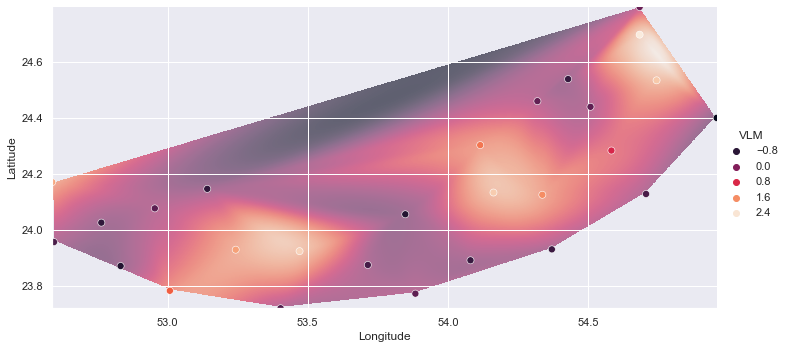

In [68]:
sns.relplot(x="Longitude", y="Latitude", hue="VLM", data=vlm, s=50, palette="rocket", height=10)
plt.imshow(vlm_grid, extent=(x_min, x_max, y_min, y_max), origin='lower', alpha=0.6)
plt.show()

In [84]:
import copy
elevation_new = copy.deepcopy(elevation)

In [87]:
elevation_new = elevation_new.astype('float')
elevation_new[elevation_new == 32767] = np.nan

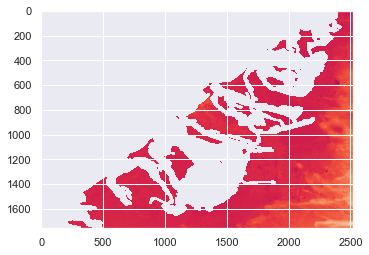

In [91]:
plt.imshow(elevation_new)

In [100]:
# plt.scatter(elevation_df.x, elevation_df.y, c=elevation_df.value)

In [96]:
elevation_df.value.describe()

count    1.789661e+06
mean     7.112559e+00
std      9.998245e+00
min     -8.900000e+01
25%      1.000000e+00
50%      3.000000e+00
75%      9.000000e+00
max      8.300000e+01
Name: value, dtype: float64

In [102]:
elevation_new

array([[nan, nan, nan, ..., -2., -4., -4.],
       [nan, nan, nan, ..., -3., -4., -6.],
       [nan, nan, nan, ..., -3., -4., -4.],
       ...,
       [nan, nan, nan, ..., 39., 38., 38.],
       [nan, nan, nan, ..., 38., 39., 40.],
       [nan, nan, nan, ..., 37., 38., 39.]])

### Observation:
The values from two variables (elevation dataframe and elevation array) are somehow different. I'm not looking into this right now as I only need the coordinates.

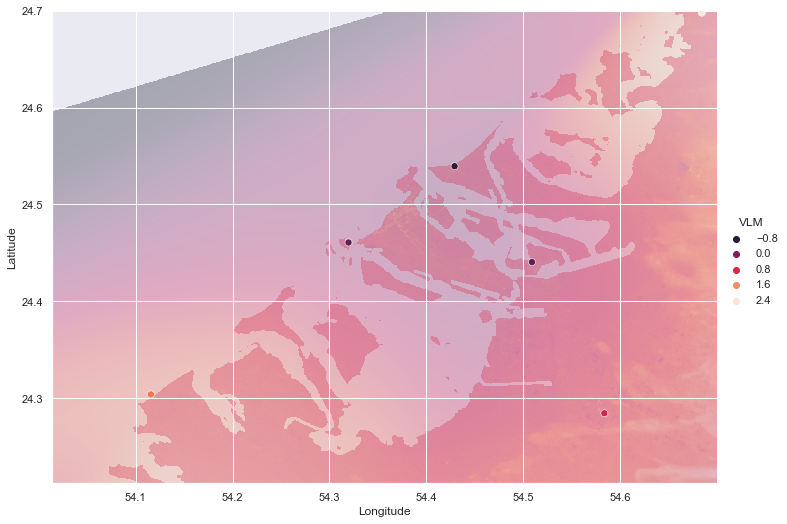

In [222]:
sns.relplot(x="Longitude", y="Latitude", hue="VLM", data=vlm, s=50, palette="rocket", height=10)
plt.imshow(vlm_grid, extent=(x_min, x_max, y_min, y_max), origin='lower', alpha=0.3)
plt.imshow(elevation_new, alpha=0.3, extent=(elevation_df.x.min(), elevation_df.x.max(), elevation_df.y.min(), elevation_df.y.max()))
plt.show()

Idea: flatten the coordinate grid into pairs of coordinates to use as inputs for another interpolation

In [141]:
vlm_inter_points = np.hstack((xv.reshape(-1, 1), yv.reshape(-1, 1)))
vlm_inter_points.shape

(2875184, 2)

In [143]:
vlm_inter_values = vlm_grid.flatten()
vlm_inter_values.shape

(2875184,)

In [146]:
elev_coor = elevation_df[['x', 'y']].values
elev_coor.shape

(1789661, 2)

In [147]:
elev_grid_0 = griddata(vlm_points, vlm_values, elev_coor, method='cubic') # without pre-interpolation
elev_grid_1 = griddata(vlm_inter_points, vlm_inter_values, elev_coor, method='cubic') # with pre-interpolation

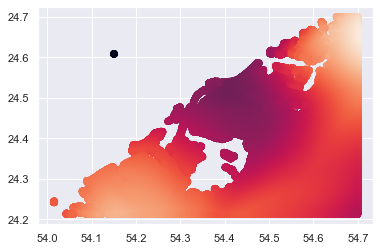

In [153]:
plt.scatter(x=elevation_df.x, y=elevation_df.y, c=elev_grid_0)

Using the dataframe seems to provide scattered points still. Idea: interpolate onto an elevation grid (to be created) then drop values where nan in original array?

In [156]:
# elev_idk = griddata(vlm_inter_points, vlm_inter_values, elevation_new, method='cubic')
# ValueError: number of dimensions in xi does not match x

In [169]:
elevation_new.shape

(1758, 2521)

In [170]:
# Find elevation map boundaries
x_min_elev = dataset.bounds.left
x_max_elev = dataset.bounds.right
y_min_elev = dataset.bounds.bottom
y_max_elev = dataset.bounds.top

In [174]:
# Create elevation meshgrid
nyy, nxx = elevation_new.shape
xx = np.linspace(x_min_elev, x_max_elev, nxx)
yy = np.linspace(y_min_elev, y_max_elev, nyy)
xxv, yyv = np.meshgrid(xx, yy)

In [175]:
xxv.shape, yyv.shape

((1758, 2521), (1758, 2521))

In [216]:
elev_grid = griddata(vlm_inter_points, vlm_inter_values, (xxv, yyv), method='linear')

In [190]:
np.unique(elev_grid)

array([-2.54893704, -2.5483755 , -2.54837116, ...,         nan,
               nan,         nan])

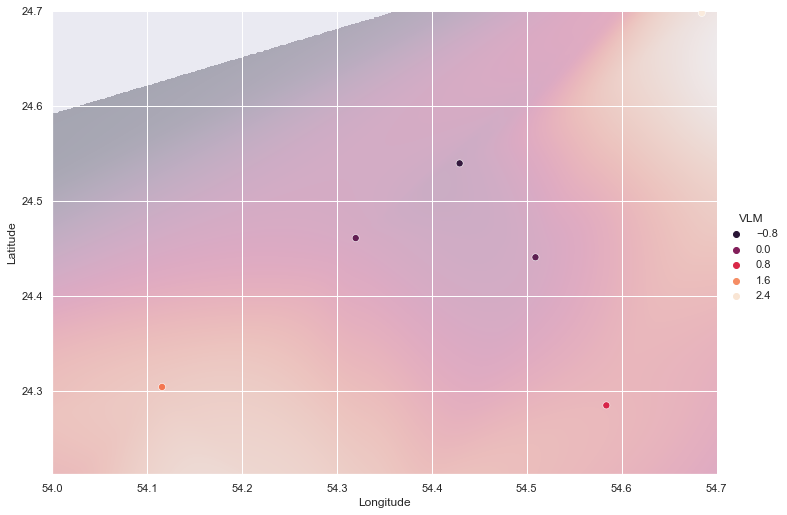

In [227]:
sns.relplot(x="Longitude", y="Latitude", hue="VLM", data=vlm, s=50, palette="rocket", height=10)
plt.imshow(elev_grid, extent=(x_min_elev, x_max_elev, y_min_elev, y_max_elev), origin="lower", alpha=0.3)
plt.show()

In [235]:
elev_grid_copy = copy.deepcopy(elev_grid)

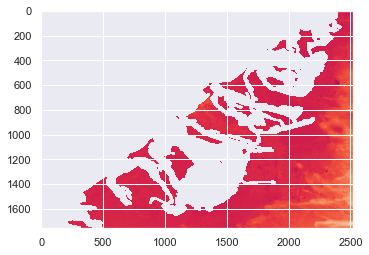

In [223]:
plt.imshow(elevation_new)

In [238]:
elev_grid_copy[np.isnan(np.flip(elevation_new, 0))] = np.nan
# Needs to flip elevation array vertically. I don't really understand why.

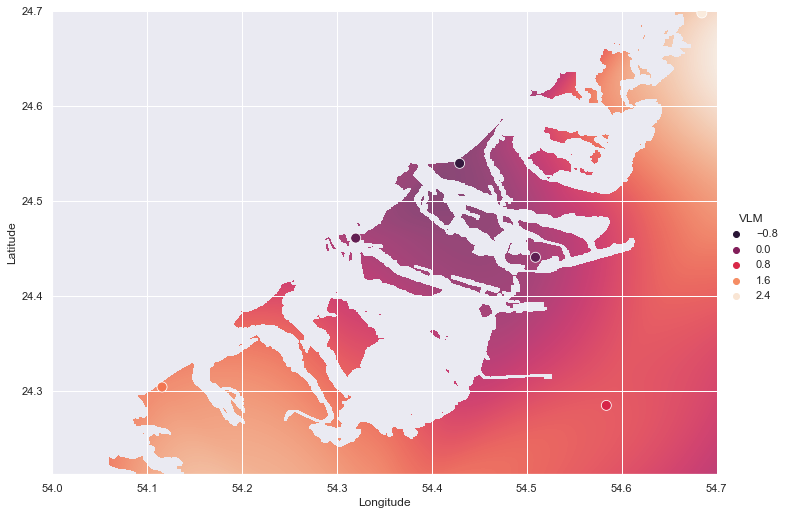

In [246]:
sns.relplot(x="Longitude", y="Latitude", hue="VLM", data=vlm, s=100, edgecolor="white", palette="rocket", height=10)
plt.imshow(elev_grid_copy, extent=(x_min_elev, x_max_elev, y_min_elev, y_max_elev), origin='lower', alpha=0.8)
plt.show()

# Sea level rise
## Adjusted elevation = Initial land elevation - project sea level + VLM + uncertainties
Note: elev_grid currently has interpolated VLM data

In [247]:
slr = pd.read_excel('data.xls', sheet_name=1, skiprows=15)[['Scenario', 'RSL in 2030 (cm)',
                                                            'RSL in 2050 (cm)', 'RSL in 2080 (cm)', 'RSL in 2100 (cm)']]

In [248]:
slr_new = slr.loc[(slr.Scenario == '0.3 - LOW') |  (slr.Scenario == '2.5 - HIGH')]
slr_new['SL'] = slr_new.sum(axis=1)
slr_new

<ipython-input-248-bb687f515d63>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slr_new['SL'] = slr_new.sum(axis=1)


,Scenario,RSL in 2030 (cm),RSL in 2050 (cm),RSL in 2080 (cm),RSL in 2100 (cm),SL
1,0.3 - LOW,10,15,21,22,68
17,2.5 - HIGH,55,114,241,357,767


In [265]:
ae_low = copy.deepcopy(elev_grid_copy)
ae_high = copy.deepcopy(elev_grid_copy)

In [266]:
ae_low = np.flip(elevation_new, 0) - slr_new.iloc[0].SL + ae_low
ae_high = np.flip(elevation_new, 0) - slr_new.iloc[1].SL + ae_high

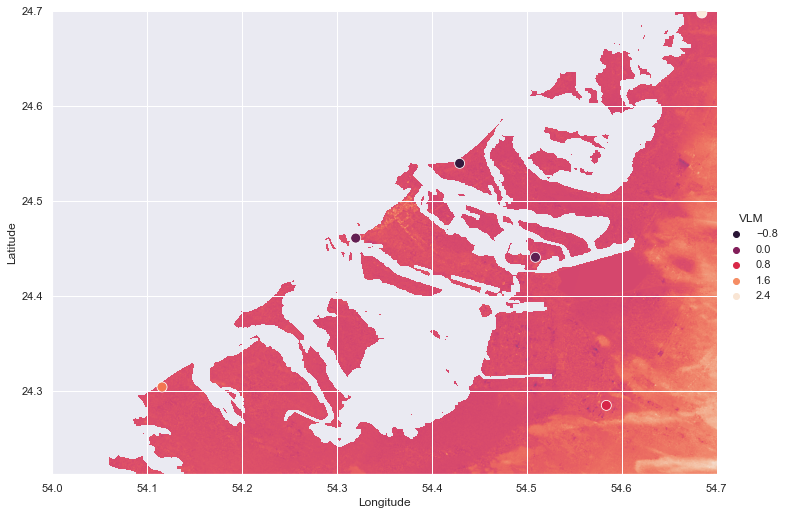

In [267]:
sns.relplot(x="Longitude", y="Latitude", hue="VLM", data=vlm, s=100, edgecolor="white", palette="rocket", height=10)
plt.imshow(ae_low, extent=(x_min_elev, x_max_elev, y_min_elev, y_max_elev), origin='lower', alpha=0.8)
plt.show()

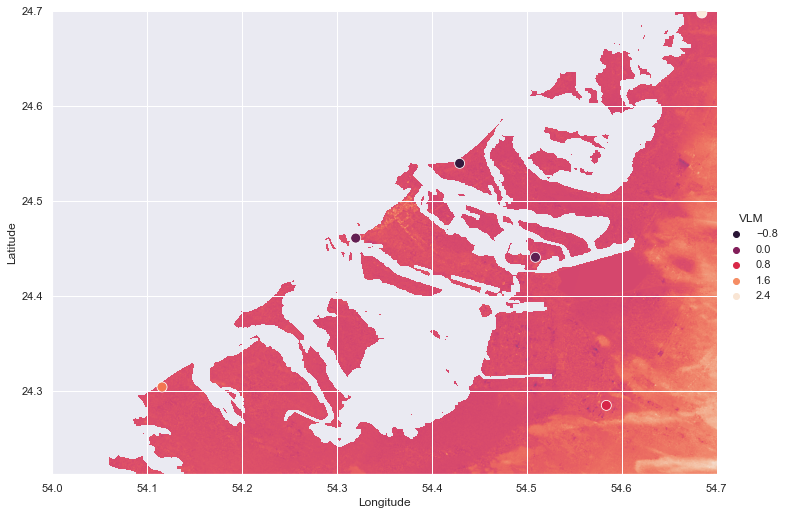

In [268]:
sns.relplot(x="Longitude", y="Latitude", hue="VLM", data=vlm, s=100, edgecolor="white", palette="rocket", height=10)
plt.imshow(ae_high, extent=(x_min_elev, x_max_elev, y_min_elev, y_max_elev), origin='lower', alpha=0.8)
plt.show()

In [286]:
ae_min = min(ae_low[~np.isnan(ae_low)].min(), ae_high[~np.isnan(ae_high)].min())
ae_max = max(ae_low[~np.isnan(ae_low)].max(), ae_high[~np.isnan(ae_high)].max())
ae_min, ae_max

(-855.2849304485795, 15.144522933179102)

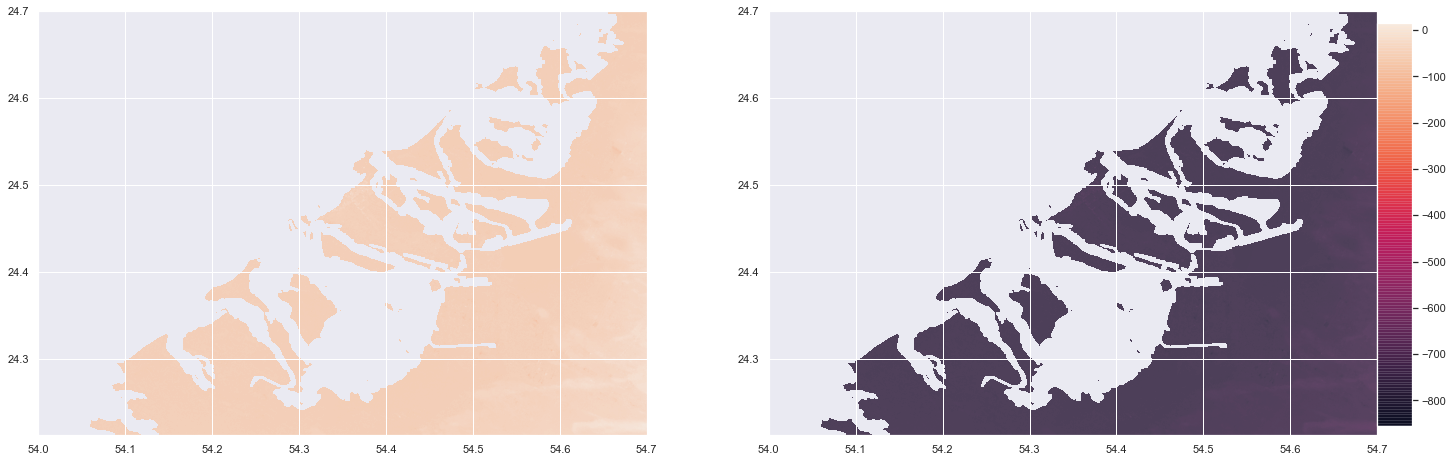

In [289]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(24, 8))
im1 = ax1.imshow(ae_low, extent=(x_min_elev, x_max_elev, y_min_elev, y_max_elev), origin='lower', alpha=0.8, vmin=ae_min, vmax=ae_max)
im2 = ax2.imshow(ae_high, extent=(x_min_elev, x_max_elev, y_min_elev, y_max_elev), origin='lower', alpha=0.8, vmin=ae_min, vmax=ae_max)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(im2, cax=cbar_ax)

# points1 = ax1.imshow(ae_low, extent=(x_min_elev, x_max_elev, y_min_elev, y_max_elev), origin='lower', alpha=0.8)
# ax1.set_title('AE - Low')
# norm_colors1 = ax1.pcolor(xx, yy, elevation_new, vmin=ae_min, vmax=ae_max)
# fig.colorbar(points1, ax=ax1)
# points2 = ax2.imshow(ae_high, extent=(x_min_elev, x_max_elev, y_min_elev, y_max_elev), origin='lower', alpha=0.8)
# ax2.set_title('AE - High')
# fig.colorbar(points2, ax=ax2)
# plt.show()

# fig, axes = plt.subplots(nrows=2, ncols=2)
# for ax in axes.flat:
#     im = ax.imshow(np.random.random((10,10)), vmin=0, vmax=1)

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(im, cax=cbar_ax)

In [291]:
np.min(ae_low[~np.isnan(ae_low)]), np.max(ae_low[~np.isnan(ae_low)]), np.mean(ae_low[~np.isnan(ae_low)])

(-156.2849304485795, 15.144522933179102, -60.09745198649704)

In [292]:
np.min(ae_high[~np.isnan(ae_high)]), np.max(ae_high[~np.isnan(ae_high)]), np.mean(ae_high[~np.isnan(ae_high)])

(-855.2849304485795, -683.8554770668209, -759.097451986497)